# 1. Konfigurasi & Setup

In [ ]:
!pip install -q pandas nltk contractions deep-translator langdetect retry wordcloud

from google.colab import drive
import nltk

drive.mount('/content/drive')

# NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.1 MB/s eta 0:00:00
Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
from pathlib import Path

BASE = "/content/drive/MyDrive/PBA"

CSV_PATH = f"{BASE}/hasil_scrape_UBER.csv"
AUG_PATH = f"{BASE}/hasil_scrape_UBER_AUGMENTED_FINAL.csv"

# 1. File Input (Data Mentah Asli)
RAW_CSV_PATH = f"{BASE}/hasil_scrape_UBER.csv"

# 2. File Output setelah semua Pre-processing selesai
PROCESSED_CSV_PATH = f"{BASE}/hasil_preprocessing_UBER.csv"

# 3. File Output setelah data diberi label
LABELED_CSV_PATH = f"{BASE}/hasil_labelling_UBER.csv"

# 4. File Output data training yang sudah di-augment
AUGMENTED_TRAIN_PATH = f"{BASE}/train_augmented_UBER.csv"

# 2. Pre-Processing

## 2.1 Expansion Contractions

In [ ]:
import pandas as pd
import contractions
import re
import ast

# Membaca Data
try:
    df = pd.read_csv(CSV_PATH)
except Exception as e:
    raise Exception(f"Gagal memuat data: {e}")

# Fungsi Expansion Contractions
def expand_contractions_only(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    return contractions.fix(text)

# Menerapkan Expansion dan menyimpan
if 'Teks_Artikel_Scraped' in df.columns:
    print("1/4 Memulai Expansion Contractions...")
    df['Teks_Expanded'] = df['Teks_Artikel_Scraped'].apply(expand_contractions_only)
    df.to_csv(CSV_PATH, index=False)
    print("Expansion Contractions Selesai. Kolom 'Teks_Expanded' ditambahkan.")
else:
    print("Kolom 'Teks_Artikel_Scraped' tidak ditemukan. Proses dibatalkan.")

1/4 Memulai Expansion Contractions...
Expansion Contractions Selesai. Kolom 'Teks_Expanded' ditambahkan.


## 2.2 Tokenization & Cleaning

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
import re
import ast
import nltk

# Download the missing resource
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')


# Membaca Data (mengambil Teks_Expanded)
try:
    df = pd.read_csv(CSV_PATH)
except Exception as e:
    raise Exception(f"Gagal memuat data: {e}")

# Fungsi Tokenisasi & Pembersihan
def clean_and_tokenize(text):
    if pd.isna(text) or not isinstance(text, str):
        return []

    # Cleaning & Lowercase (Teks sudah di Expand)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+|ftp\S+', '', text, flags=re.MULTILINE) # Hapus URL
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) # Hapus Punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih

    # Tokenization
    return word_tokenize(text)

# Menerapkan Tokenization dan menyimpan
if 'Teks_Expanded' in df.columns:
    print("2/4 Memulai Tokenization & Cleaning...")
    df['Tokens'] = df['Teks_Expanded'].apply(clean_and_tokenize)
    df.to_csv(CSV_PATH, index=False)
    print("Tokenization Selesai. Kolom 'Tokens' ditambahkan.")
else:
    print("Kolom 'Teks_Expanded' tidak ditemukan. Pastikan Langkah 1 sudah selesai.")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


2/4 Memulai Tokenization & Cleaning...
Tokenization Selesai. Kolom 'Tokens' ditambahkan.


## 2.3 Stopword Removal

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import ast

# Definisikan Stop Words Set
stop_words_english_nltk = set(stopwords.words('english'))
negation_words = {
    'not', 'no', 'don', 'don\'t', 'doesn', 'doesn\'t', 'didn', 'didn\'t',
    'wouldn', 'wouldn\'t', 'couldn', 'couldn\'t', 'shouldn', 'shouldn\'t',
    'isn', 'isn\'t', 'wasn', 'wasn\'t', 'aren', 'aren\'t', 'haven', 'haven\'t',
    'hasn', 'hasn\'t', 'won', 'won\'t', 'mightn', 'mightn\'t', 'mustn', 'mustn\'t',
    'weren', 'weren\'t'
}
custom_noise_words = {
    'markets', 'hot', 'stocks', 'fear', 'greed', 'index', 'latest', 'market', 'news',
    'quote', 'data', 'provided', 'bats', 'indices', 'shown', 'real', 'time',
    'except', 'refreshed', 'minutes', 'factset', 'research', 'systems', 'inc',
    'rights', 'reserved', 'chicago', 'mercantile', 'property', 'exchange',
    'licensors', 'dow', 'jones', 'branded', 'calculated',
    'marketed', 'opco', 'subsidiary', 'llc', 'licensed', 'services',
    'trademark', 'holdings', 'content', 'copyright', 'fair',
    'value', 'indexarb', 'holidays', 'hours', 'copp', 'clark',
    'limited', 'cable', 'network', 'warner', 'bros', 'discovery', 'company',
    'sans', 'cnn', 'follow', 'pic', 'twitter', 'com', 'editor', 'note', 'et',
    'corp', 'eats', 'mcdonald', 'tm', 'gm', 'dnzof',
    'mcd', 'jstty', 'ab5', 'prop', '22', 'iwgb', 'adcu', 'u', 'say', 'said', 'says', 'tell', 'told', 'according', 'allege', 'alleges'
}
temp_stopwords = stop_words_english_nltk.difference(negation_words)
all_stop_words = temp_stopwords.union(custom_noise_words)


# Membaca Data (mengambil Tokens)
try:
    df = pd.read_csv(CSV_PATH)
except Exception as e:
    raise Exception(f"Gagal memuat data: {e}")

# Fungsi Stop Word Removal
def remove_stopwords_from_tokens(tokens_list_str):
    if pd.isna(tokens_list_str): return []
    try: tokens = ast.literal_eval(tokens_list_str)
    except (ValueError, TypeError): return []

    filtered_tokens = [
        word for word in tokens
        if word not in all_stop_words and len(word) > 1 and not word.isdigit()
    ]
    return filtered_tokens

# Menerapkan Stop Word Removal dan menyimpan
if 'Tokens' in df.columns:
    print("3/4 Memulai Stop Word Removal...")
    df['Tokens_Clean'] = df['Tokens'].apply(remove_stopwords_from_tokens)
    df.to_csv(CSV_PATH, index=False)
    print("Stop Word Removal Selesai. Kolom 'Tokens_Clean' ditambahkan.")
else:
    print("Kolom 'Tokens' tidak ditemukan. Pastikan Langkah 2 sudah selesai.")

3/4 Memulai Stop Word Removal...
Stop Word Removal Selesai. Kolom 'Tokens_Clean' ditambahkan.


## 2.4 Lemmatization

In [ ]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import ast

# Inisialisasi Tools
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

# Membaca Data (mengambil Tokens_Clean)
try:
    df = pd.read_csv(CSV_PATH)
except Exception as e:
    raise Exception(f"Gagal memuat data: {e}")

# Fungsi Lemmatization
def lemmatize_tokens(tokens_list_str):
    if pd.isna(tokens_list_str): return []
    try: tokens = ast.literal_eval(tokens_list_str)
    except (ValueError, TypeError): return []

    # Lakukan POS tagging pada tokens bersih
    pos_tags = nltk.pos_tag(tokens)
    lemmas = []
    for word, tag in pos_tags:
        w_n_tag = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=w_n_tag)
        lemmas.append(lemma)

    return lemmas

# Menerapkan Lemmatization dan menyimpan
if 'Tokens_Clean' in df.columns:
    print("4/4 Memulai Lemmatization...")
    df['Teks_Lemma_Final'] = df['Tokens_Clean'].apply(lemmatize_tokens)
    df.to_csv(CSV_PATH, index=False)
    print("Lemmatization Selesai. Kolom 'Teks_Lemma_Final' ditambahkan.")

    print("\nContoh Hasil Final Teks:")
    print(df[['Teks_Artikel_Scraped', 'Teks_Lemma_Final']].head())
else:
    print("Kolom 'Tokens_Clean' tidak ditemukan. Pastikan Langkah 3 sudah selesai.")

4/4 Memulai Lemmatization...
Lemmatization Selesai. Kolom 'Teks_Lemma_Final' ditambahkan.

Contoh Hasil Final Teks:
                                Teks_Artikel_Scraped  \
0  Markets Hot Stocks Fear & Greed Index Latest M...   
1  Markets Hot Stocks Fear & Greed Index Latest M...   
2  Markets Hot Stocks Fear & Greed Index Latest M...   
3  Markets Hot Stocks Fear & Greed Index Latest M...   
4  Markets Hot Stocks Fear & Greed Index Latest M...   

                                    Teks_Lemma_Final  
0  [u, government, thursday, sue, uber, technolog...  
1  [need, uber, one, without, driver, beginning, ...  
2  [uber, launch, new, service, call, route, shar...  
3  [uber, pilot, new, option, u, app, allow, fema...  
4  [uber, roll, new, feature, make, easy, people,...  


## 2.5 Final Cleaning

In [ ]:
import pandas as pd
import ast

# Membaca Data (mengambil Teks_Lemma_Final)
try:
    df = pd.read_csv(CSV_PATH)
except Exception as e:
    raise Exception(f"Gagal memuat data: {e}")

# Fungsi Final Cleaning
def finalize_text(tokens_list_str):
    # Pastikan input bukan NaN dan bertipe string
    if pd.isna(tokens_list_str) or not isinstance(tokens_list_str, str):
        return ""

    try:
        # Mengubah representasi string list menjadi list Python (['a', 'b'] -> ['a', 'b'])
        tokens = ast.literal_eval(tokens_list_str)

        # Menggabungkan elemen list menjadi satu string dipisahkan spasi (['a', 'b'] -> 'a b')
        return " ".join(tokens)
    except (ValueError, TypeError):
        # Menangani kasus jika evaluasi gagal
        return ""

# Menerapkan Final Cleaning dan menyimpan
if 'Teks_Lemma_Final' in df.columns:
    print("5/5 Memulai Final Cleaning (Menghilangkan Kurung Kotak & Koma)...")

    # Membuat kolom baru 'Teks_Final_Clean'
    df['Teks_Final_Clean'] = df['Teks_Lemma_Final'].apply(finalize_text)

    # Menyimpan DataFrame yang diperbarui
    df.to_csv(CSV_PATH, index=False)
    print("Final Cleaning Selesai. Kolom 'Teks_Final_Clean' ditambahkan.")

    print("\nContoh Hasil Final Teks:")
    # Tampilkan perbandingan antara kolom akhir pemrosesan yang lama dan yang baru
    print(df[['Teks_Lemma_Final', 'Teks_Final_Clean']].head())
else:
    print("Kolom 'Teks_Lemma_Final' tidak ditemukan. Pastikan Langkah 4 sudah selesai.")

5/5 Memulai Final Cleaning (Menghilangkan Kurung Kotak & Koma)...
Final Cleaning Selesai. Kolom 'Teks_Final_Clean' ditambahkan.

Contoh Hasil Final Teks:
                                    Teks_Lemma_Final  \
0  ['u', 'government', 'thursday', 'sue', 'uber',...   
1  ['need', 'uber', 'one', 'without', 'driver', '...   
2  ['uber', 'launch', 'new', 'service', 'call', '...   
3  ['uber', 'pilot', 'new', 'option', 'u', 'app',...   
4  ['uber', 'roll', 'new', 'feature', 'make', 'ea...   

                                    Teks_Final_Clean  
0  u government thursday sue uber technology accu...  
1  need uber one without driver beginning tuesday...  
2  uber launch new service call route share carpo...  
3  uber pilot new option u app allow female passe...  
4  uber roll new feature make easy people age acc...  


#3. EDA (Exploratory Data Analysis)

##3.1 EDA Tahap Awal dan Audit Kualitas Data

✅ Data berhasil dimuat. Total baris awal: 171
   - Baris NA dan Duplikasi dihapus. Sisa data: 171

[A] Top 20 Kata Terbanyak (Mentah) berhasil dihitung.


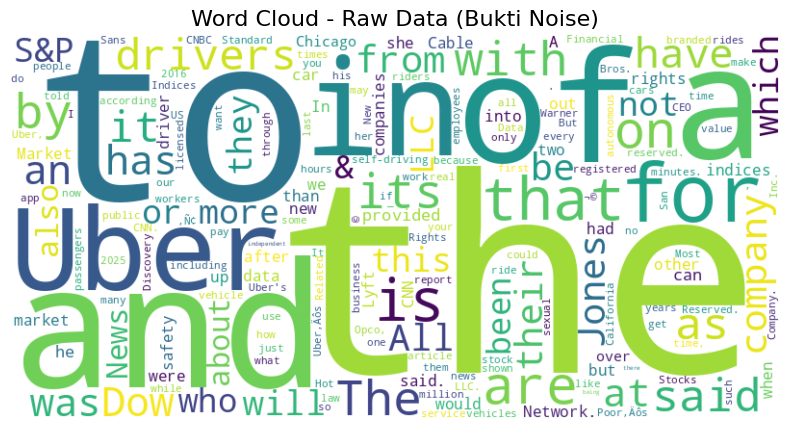

/tmp/ipython-input-3797975351.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


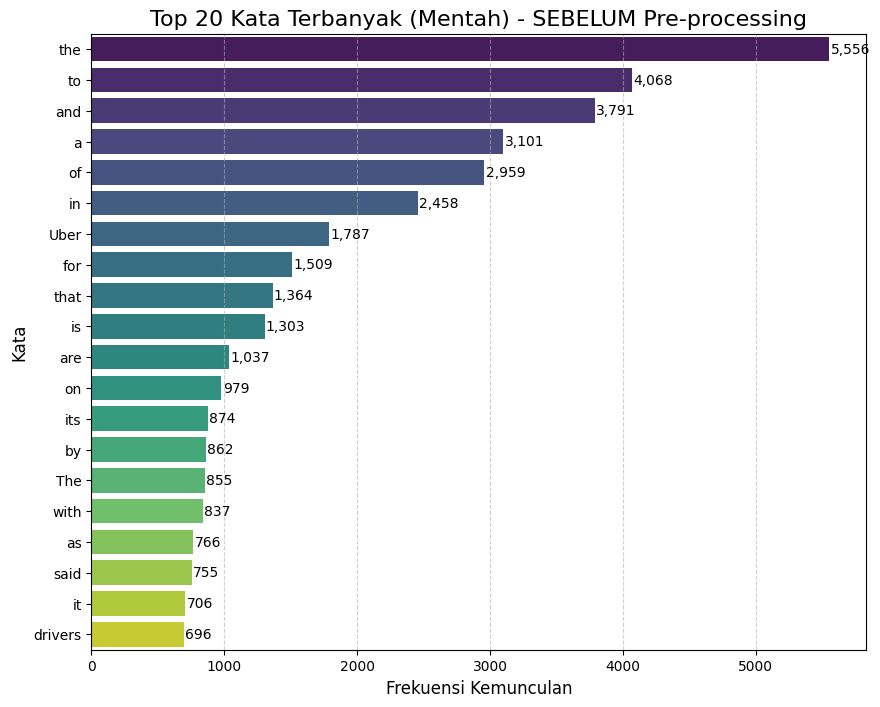

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import os
import nltk

# Asumsi CSV_PATH sudah didefinisikan di sel sebelumnya

# --- 1. Pemuatan Data dan Audit Kualitas ---
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Error: File tidak ditemukan di {CSV_PATH}. Pastikan path file CSV Anda benar.")

df = pd.read_csv(CSV_PATH)
print(f"✅ Data berhasil dimuat. Total baris awal: {len(df)}")

# Audit Kualitas Data
initial_rows = len(df)
df.dropna(subset=['Teks_Artikel_Scraped'], inplace=True)
df.drop_duplicates(subset=['Teks_Artikel_Scraped'], inplace=True)
print(f"   - Baris NA dan Duplikasi dihapus. Sisa data: {len(df)}")

# --- 2. Perhitungan Frekuensi Kata Mentah ---

def get_raw_words_for_counting(text):
    """Fungsi tokenisasi PALING MENTAH (hanya split() berdasarkan spasi)."""
    if pd.isna(text) or not isinstance(text, str):
        return []
    return text.split()

all_raw_tokens = []
for text in df['Teks_Artikel_Scraped']:
    all_raw_tokens.extend(get_raw_words_for_counting(text))

raw_word_counts = Counter(all_raw_tokens)
top_20_raw = raw_word_counts.most_common(20)

words = [item[0] for item in top_20_raw]
counts = [item[1] for item in top_20_raw]

print("\n[A] Top 20 Kata Terbanyak (Mentah) berhasil dihitung.")

# --- 3. VISUALISASI ---

# 3.1. Word Cloud Data Mentah
wordcloud_raw = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False
).generate_from_frequencies(raw_word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_raw, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Raw Data (Bukti Noise)', fontsize=16)
plt.show()

# 3.2. Bar Chart Top 20 Kata Mentah
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=counts,
    y=words,
    palette="viridis"
)

plt.title('Top 20 Kata Terbanyak (Mentah) - SEBELUM Pre-processing', fontsize=16)
plt.xlabel('Frekuensi Kemunculan', fontsize=12)
plt.ylabel('Kata', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# KODE UNTUK MENAMPILKAN NILAI (JUMLAH) PADA BATANG
for i, count in enumerate(counts):
    ax.text(
        count + 10,
        i,
        f'{count:,}',
        va='center'
    )

plt.show()


[D] Analisis Panjang Teks Mentah (Word Count):
count      171
mean       819
std        485
min         55
25%        518
50%        720
75%      1,022
max      3,133
Name: Word_Count_Raw, dtype: object


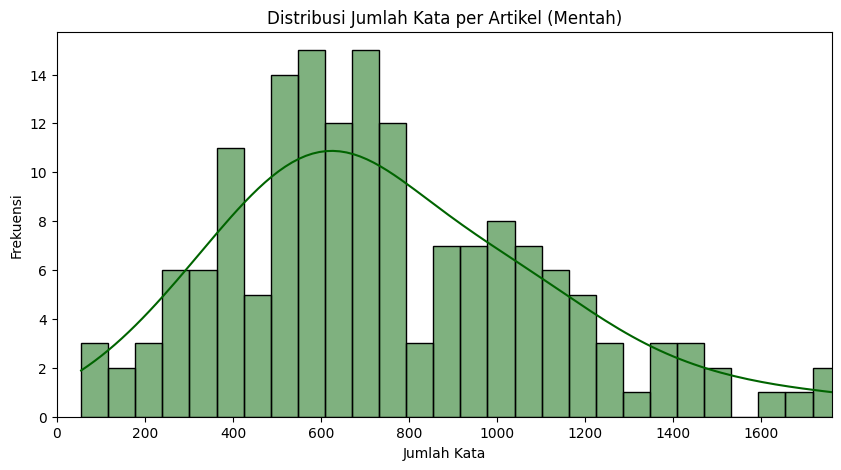

In [ ]:
print("\n[D] Analisis Panjang Teks Mentah (Word Count):")

# Hitung jumlah kata pada teks mentah
df['Word_Count_Raw'] = df['Teks_Artikel_Scraped'].astype(str).apply(lambda x: len(x.split()))

# Statistik Deskriptif
print(df['Word_Count_Raw'].describe().apply(lambda x: f"{x:,.0f}"))

# Visualisasi Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['Word_Count_Raw'], bins=50, kde=True, color='darkgreen')
plt.title('Distribusi Jumlah Kata per Artikel (Mentah)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.xlim(0, df['Word_Count_Raw'].quantile(0.95))
plt.show()
#

##3.2 Validasi Pra-pemrosesan dan Analisis Fitur Teks

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/tmp/ipython-input-1878465781.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts, y=words, palette="viridis")


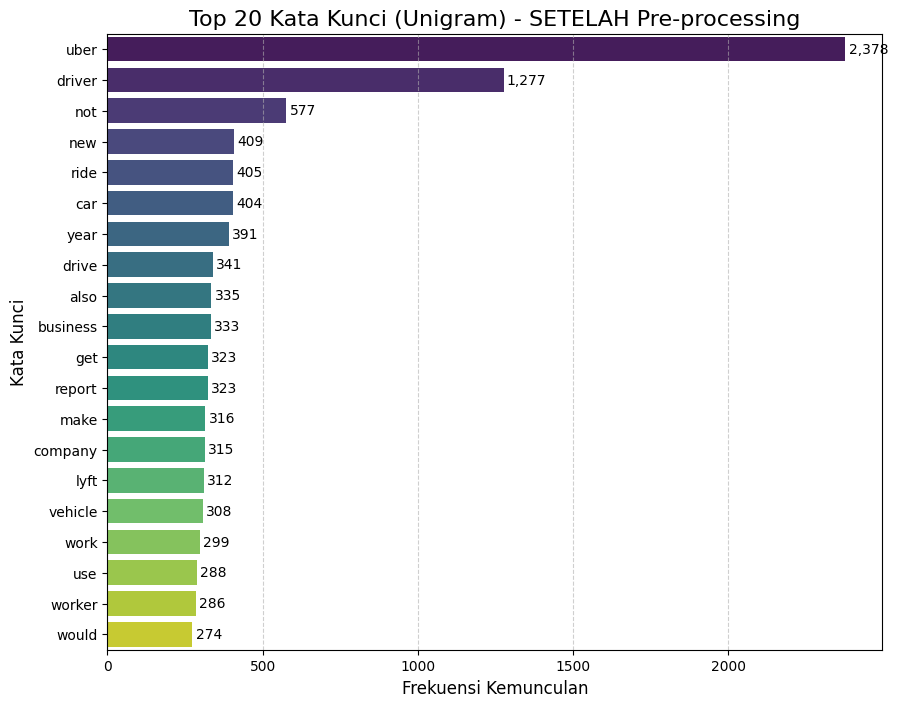

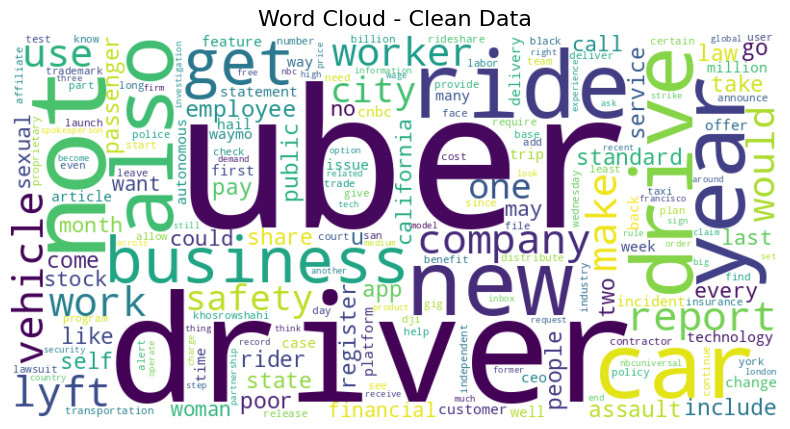

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import ast
import nltk

# NLTK Bigram/Trigram/POS tagger tools
try:
    # Cek apakah resource yang dibutuhkan sudah terunduh
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# --- Persiapan Data ---
# df sudah dimuat dan kolom Teks_Final_Clean sudah dibuat.
df.dropna(subset=['Teks_Final_Clean'], inplace=True)

# Gabungkan semua teks bersih dan tokenisasi
all_clean_text = ' '.join(df['Teks_Final_Clean'].astype(str))
clean_tokens = all_clean_text.split()

# Hitung Frekuensi Kata
clean_word_counts = Counter(clean_tokens)
top_20_clean = clean_word_counts.most_common(20)

words = [item[0] for item in top_20_clean]
counts = [item[1] for item in top_20_clean]

# --- 1. Visualisasi Bar Chart Top 20 Kata Kunci ---
plt.figure(figsize=(10, 8))
ax = sns.barplot(x=counts, y=words, palette="viridis")

plt.title('Top 20 Kata Kunci (Unigram) - SETELAH Pre-processing', fontsize=16)
plt.xlabel('Frekuensi Kemunculan', fontsize=12)
plt.ylabel('Kata Kunci', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Menambahkan nilai (jumlah) pada batang
for i, count in enumerate(counts):
    ax.text(
        count + 10,
        i,
        f'{count:,}',
        va='center'
    )
plt.show()

# --- 2. Visualisasi Word Cloud Data Bersih ---
wordcloud_clean = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False
).generate_from_frequencies(clean_word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_clean, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Clean Data', fontsize=16)
plt.show()


[D] Distribusi Panjang Teks (Word Count) - SETELAH Cleaning:
count      171
mean       408
std        260
min         20
25%        239
50%        337
75%        502
max      1,696
Name: Word_Count_Clean, dtype: object


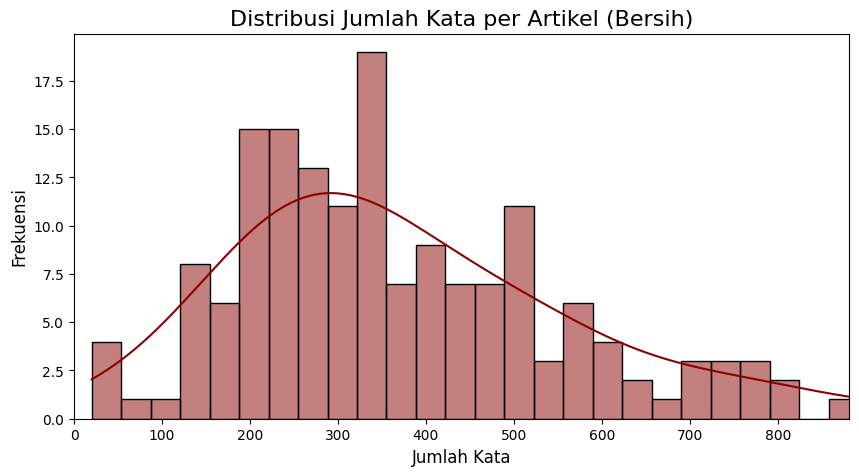

In [ ]:
print("\n[D] Distribusi Panjang Teks (Word Count) - SETELAH Cleaning:")

# Hitung jumlah kata pada teks bersih
df['Word_Count_Clean'] = df['Teks_Final_Clean'].astype(str).apply(lambda x: len(x.split()))

# Statistik Deskriptif
print(df['Word_Count_Clean'].describe().apply(lambda x: f"{x:,.0f}"))

# Visualisasi Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['Word_Count_Clean'], bins=50, kde=True, color='darkred')
plt.title('Distribusi Jumlah Kata per Artikel (Bersih)', fontsize=16)
plt.xlabel('Jumlah Kata', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.xlim(0, df['Word_Count_Clean'].quantile(0.95))
plt.show()

# 4. Labelling

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Mengunduh VADER Lexicon...


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Membaca data yang sudah diproses...

Memberikan label sentimen pada setiap artikel...


Menganalisis Sentimen:   0%|          | 0/171 [00:00<?, ?it/s]


Proses labeling selesai.

--- Hasil Pelabelan ---

Distribusi Jumlah Label:
sentiment_label
POSITIF    109
NEGATIF     62
Name: count, dtype: int64

Distribusi Persentase Label:
sentiment_label
POSITIF    63.74%
NEGATIF    36.26%
Name: proportion, dtype: object

Membuat visualisasi distribusi label (Count Plot)...


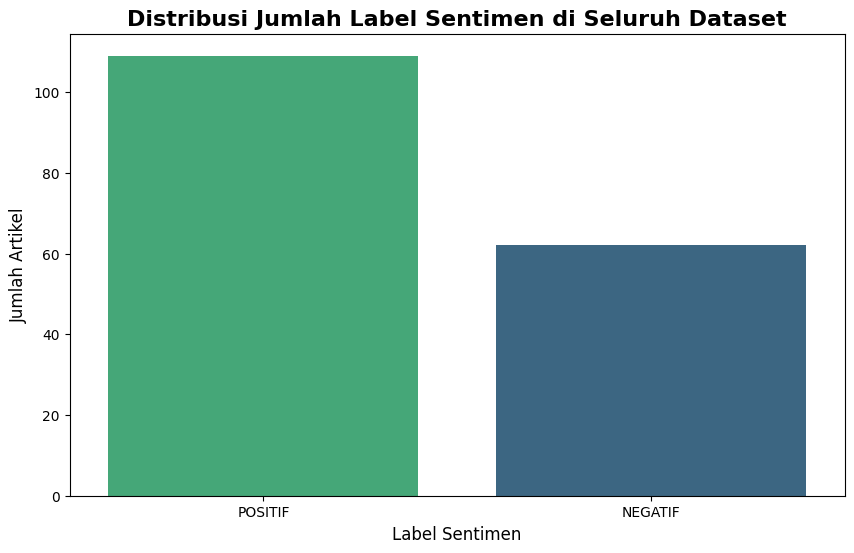


Membuat visualisasi distribusi label (Pie Chart)...


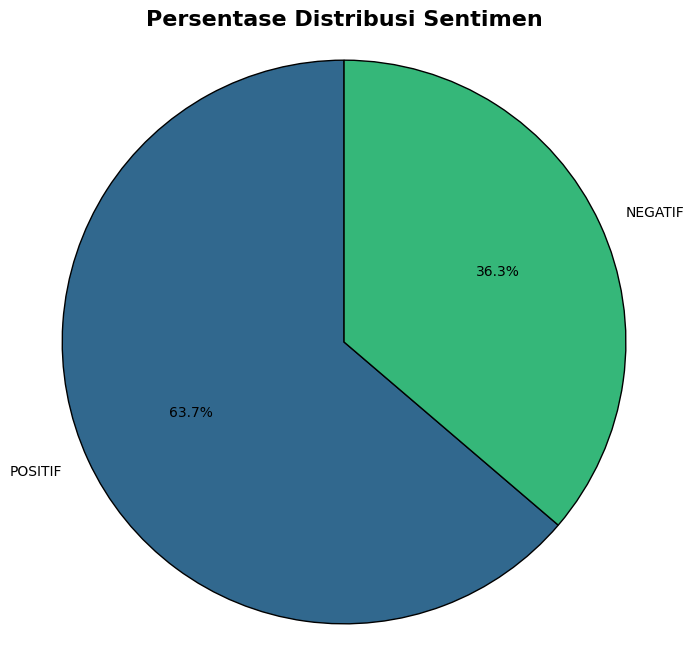


Contoh Acak Hasil Pelabelan:
                                      Teks_Final_Clean sentiment_label
104  article uber alphabet waymo offer robotaxi rid...         POSITIF
137  profile alert no new alert uber lose another l...         NEGATIF
144  profile alert no new alert pretty tough week u...         NEGATIF
65   anyone look wouldn hard uncover talal chammout...         NEGATIF
143  nbcnews last week uber report result second qu...         POSITIF


In [ ]:

# Download lexicon yang dibutuhkan oleh VADER (hanya perlu sekali)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    print("Mengunduh VADER Lexicon...")
    nltk.download('vader_lexicon')

# Membaca data
try:
    # Asumsi CSV_PATH sudah didefinisikan dan berisi data yang sudah diproses ('Teks_Final_Clean')
    df = pd.read_csv(CSV_PATH)
    print("Membaca data yang sudah diproses...")
except Exception as e:
    raise Exception(f"Gagal memuat data: {e}")

# Inisialisasi Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Membuat Fungsi Pelabelan
def get_sentiment_label(text):
    """
    Menganalisis teks dan mengembalikan label sentimen berdasarkan skor compound VADER.
    - POSITIF jika skor >= 0.05
    - NEGATIF jika skor <= -0.05
    - NETRAL jika di antara -0.05 dan 0.05
    """
    if not isinstance(text, str):
        return 'NETRAL'

    scores = sia.polarity_scores(text)
    compound_score = scores['compound']

    if compound_score >= 0.05:
        return 'POSITIF'
    elif compound_score <= -0.05:
        return 'NEGATIF'
    else:
        return 'NETRAL'

# Menerapkan Fungsi ke DataFrame
print("\nMemberikan label sentimen pada setiap artikel...")
tqdm.pandas(desc="Menganalisis Sentimen")

TEXT_COL = 'Teks_Final_Clean'
LABEL_COL = 'sentiment_label'
df[LABEL_COL] = df[TEXT_COL].progress_apply(get_sentiment_label)

print("\nProses labeling selesai.")

# --- Meninjau Hasil Pelabelan ---
print("\n--- Hasil Pelabelan ---")

# Distribusi Label (Jumlah)
print("\nDistribusi Jumlah Label:")
label_distribution = df[LABEL_COL].value_counts()
print(label_distribution)

# Distribusi Label (Persentase)
label_percentage = df[LABEL_COL].value_counts(normalize=True) * 100
print("\nDistribusi Persentase Label:")
print(label_percentage.round(2).astype(str) + '%')

# Visualisasi 1: Grafik Batang (Count Plot)
print("\nMembuat visualisasi distribusi label (Count Plot)...")
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=LABEL_COL, order=label_distribution.index, palette='viridis', hue=LABEL_COL, legend=False)
plt.title('Distribusi Jumlah Label Sentimen di Seluruh Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Label Sentimen', fontsize=12)
plt.ylabel('Jumlah Artikel', fontsize=12)
plt.show()

# --- TAMBAHAN: Visualisasi 2: Grafik Lingkaran (Pie Chart) ---
print("\nMembuat visualisasi distribusi label (Pie Chart)...")

plt.figure(figsize=(8, 8))
plt.pie(
    label_distribution,
    labels=label_distribution.index,
    autopct='%1.1f%%', # Menampilkan persentase dengan satu desimal
    startangle=90,
    colors=sns.color_palette("viridis", len(label_distribution)),
    wedgeprops={"edgecolor": "black", 'linewidth': 1}
)
plt.title('Persentase Distribusi Sentimen', fontsize=16, fontweight='bold')
plt.axis('equal') # Memastikan lingkaran sempurna
plt.show()
# --- AKHIR TAMBAHAN ---


# Simpan hasil labeling ke file baru
# Asumsi LABELED_CSV_PATH sudah didefinisikan
df.to_csv(LABELED_CSV_PATH, index=False)

# Contoh Hasil Acak
print("\nContoh Acak Hasil Pelabelan:")
print(df[[TEXT_COL, LABEL_COL]].sample(5))


--- 1. Ringkasan Numerik Sentimen Berdasarkan Topik ---
sentiment_label  NEGATIF  NETRAL  POSITIF  TOTAL  PERCENTAGE (%)
Tag                                                             
Tech                  38       0       69    107            62.6
Business               7       0       17     24            14.0
News                   9       0        6     15             8.8
US                     6       0        1      7             4.1
Cars                   1       0        2      3             1.8
Nightly News           0       0        2      2             1.2
Americas               1       0        0      1             0.6
CNBC Explains          0       0        1      1             0.6
Finance                0       0        1      1             0.6
Leadership             0       0        1      1             0.6
CNBC Work              0       0        1      1             0.6
Opinion                0       0        1      1             0.6
Life                   0       0 

/tmp/ipython-input-1550505377.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_topic = sns.barplot(


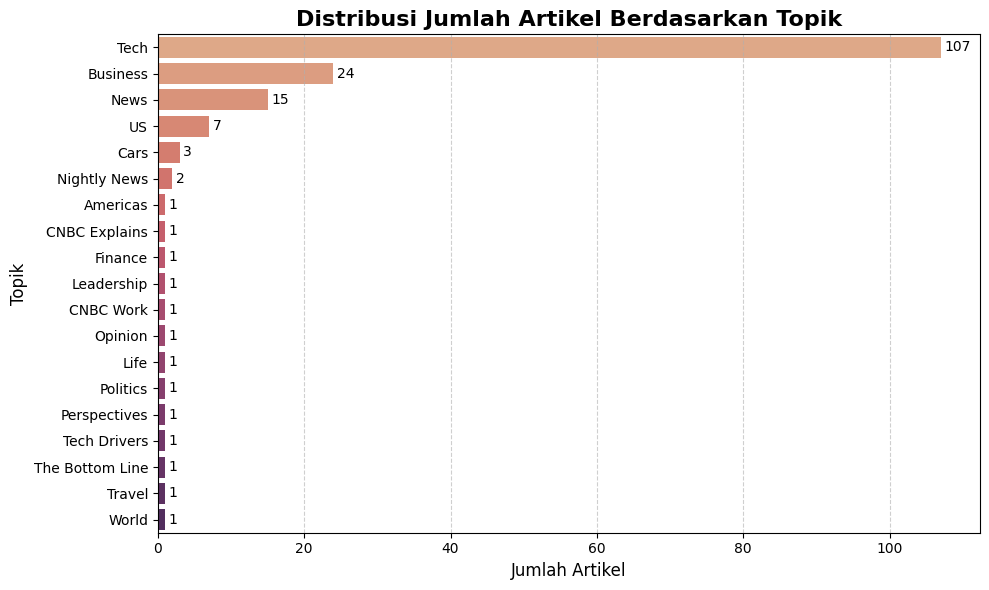

<Figure size 1200x700 with 0 Axes>

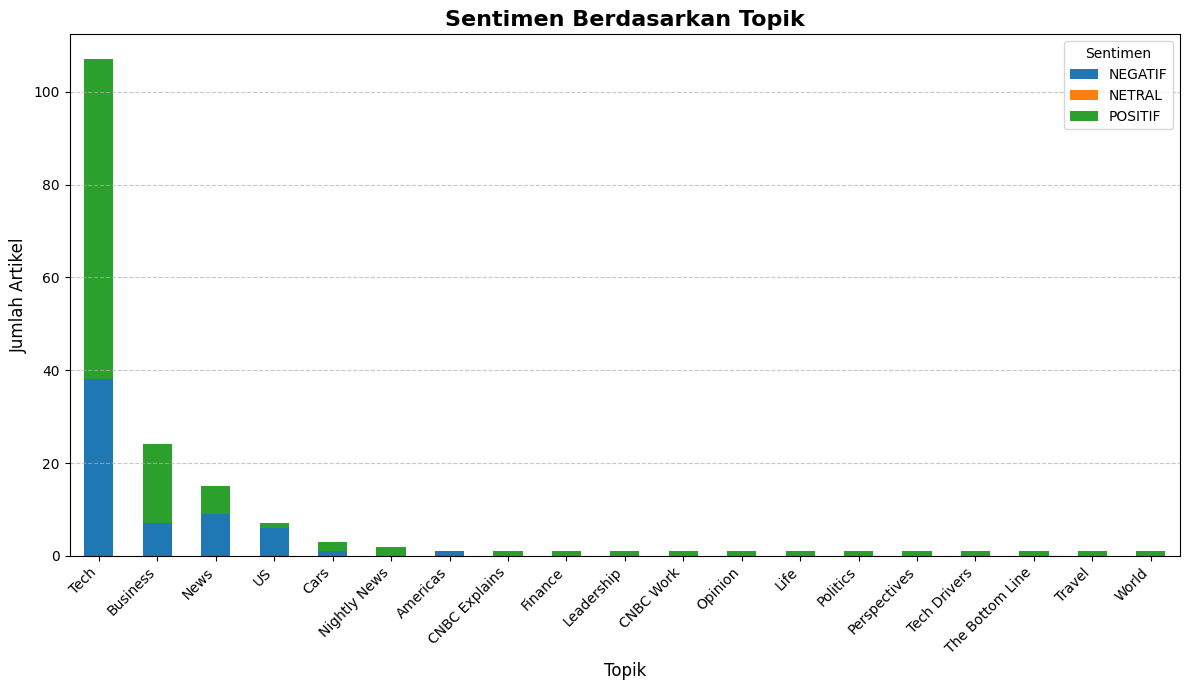

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Variabel Kolom yang Digunakan ---
TOPIC_COL = 'Tag'
SENTIMENT_COL = 'sentiment_label'
# Asumsi df sudah memiliki kolom 'Tag' dan 'sentiment_label'.

# 1. Cross-tabulation: Menghitung jumlah sentimen untuk setiap topik
topic_sentiment = pd.crosstab(df[TOPIC_COL], df[SENTIMENT_COL])

# 2. Urutkan label sentimen agar konsisten
sentiment_order = ['NEGATIF', 'NETRAL', 'POSITIF']
for col in sentiment_order:
    if col not in topic_sentiment.columns:
        topic_sentiment[col] = 0
topic_sentiment = topic_sentiment[sentiment_order]

# 3. Urutkan Topik berdasarkan total artikel
topic_total = topic_sentiment.sum(axis=1).sort_values(ascending=False)
topic_sentiment = topic_sentiment.loc[topic_total.index]


# --- A. TAMPILKAN DATA NUMERIK (Tabel Ringkasan) ---

print("\n--- 1. Ringkasan Numerik Sentimen Berdasarkan Topik ---")

# Hitung Total (Diperlukan untuk Persentase)
topic_sentiment['TOTAL'] = topic_sentiment.sum(axis=1)

# Tambahkan kolom Persentase (%)
total_articles = topic_sentiment['TOTAL'].sum()
topic_sentiment['PERCENTAGE (%)'] = (topic_sentiment['TOTAL'] / total_articles) * 100

# Format kolom persentase agar hanya menampilkan 1 desimal
pd.options.display.float_format = '{:,.1f}'.format

# Cetak tabel ringkasan yang kini mencakup persentase
print(topic_sentiment)

# Mengatur ulang format display float ke default setelah dicetak (opsional)
pd.options.display.float_format = None


# --- B. VISUALISASI GRAFIK 1: DISTRIBUSI TOPIK (Total Artikel per Topik) ---

plt.figure(figsize=(10, 6))
ax_topic = sns.barplot(
    x=topic_total.values,
    y=topic_total.index,
    palette="flare"
)

plt.title('Distribusi Jumlah Artikel Berdasarkan Topik', fontsize=16, fontweight='bold')
plt.xlabel('Jumlah Artikel', fontsize=12)
plt.ylabel('Topik', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

for i, count in enumerate(topic_total.values):
    ax_topic.text(
        count + 0.5,
        i,
        f'{int(count)}',
        va='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()


# --- C. VISUALISASI GRAFIK 2: SENTIMEN BERDASARKAN TOPIK (Stacked Bar) ---

plt.figure(figsize=(12, 7))

ax = topic_sentiment.drop(columns=['TOTAL', 'PERCENTAGE (%)']).plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)

plt.title('Sentimen Berdasarkan Topik', fontsize=16, fontweight='bold')
plt.xlabel('Topik', fontsize=12)
plt.ylabel('Jumlah Artikel', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentimen', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


ANALISIS KATA KUNCI KELAS: NEGATIF

[TOP 20 KATA KUNCI - NEGATIF]
 - uber: 905
 - driver: 514
 - not: 262
 - report: 234
 - assault: 170
 - safety: 164
 - new: 140
 - sexual: 137
 - lyft: 135
 - year: 133
 - car: 123
 - state: 120
 - company: 120
 - use: 116
 - passenger: 111
 - ride: 110
 - include: 105
 - woman: 105
 - make: 102
 - also: 101


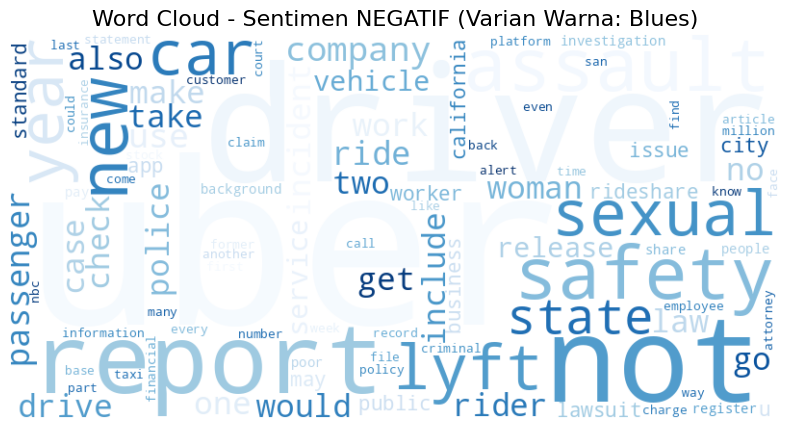


ANALISIS KATA KUNCI KELAS: NETRAL
Tidak ada data di kelas NETRAL.

ANALISIS KATA KUNCI KELAS: POSITIF

[TOP 20 KATA KUNCI - POSITIF]
 - uber: 1,473
 - driver: 763
 - not: 315
 - ride: 295
 - car: 281
 - new: 269
 - business: 266
 - year: 258
 - drive: 253
 - get: 240
 - also: 234
 - vehicle: 231
 - worker: 216
 - make: 214
 - work: 209
 - company: 195
 - employee: 195
 - city: 188
 - would: 177
 - lyft: 177


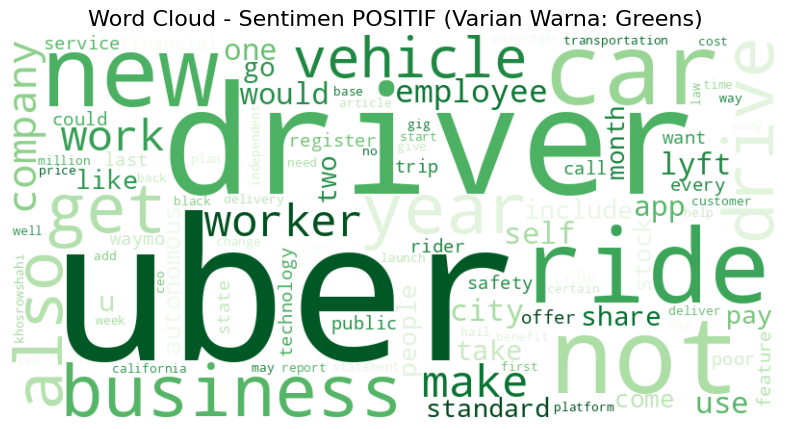


Analisis Word Cloud per Sentimen Selesai dengan variasi warna.


In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.cm as cm # Untuk Color Maps

# Daftar kelas sentimen yang akan dianalisis
SENTIMENT_CLASSES = ['NEGATIF', 'NETRAL', 'POSITIF']

# Color Maps yang bervariasi untuk setiap kelas sentimen
WC_COLORMAPS = {
    'NEGATIF': 'Blues',    # Menggunakan gradasi warna biru
    'NETRAL': 'Oranges',   # Menggunakan gradasi warna oranye
    'POSITIF': 'Greens'    # Menggunakan gradasi warna hijau
}

# --- 1. Loop Melalui Setiap Kelas Sentimen ---
for sentiment in SENTIMENT_CLASSES:
    print(f"\n=======================================================")
    print(f"ANALISIS KATA KUNCI KELAS: {sentiment}")
    print(f"=======================================================")

    # Filter DataFrame untuk kelas sentimen saat ini
    filtered_df = df[df['sentiment_label'] == sentiment]

    # Gabungkan semua teks dari kelas ini
    all_text = ' '.join(filtered_df['Teks_Final_Clean'].astype(str))

    # Tokenisasi dan Hitung Frekuensi
    tokens = all_text.split()
    if not tokens:
        print(f"Tidak ada data di kelas {sentiment}.")
        continue

    word_counts = Counter(tokens)
    top_20_words = word_counts.most_common(20)

    # --- 2. TULISAN JUMLAH KATA (Top 20) ---
    print(f"\n[TOP 20 KATA KUNCI - {sentiment}]")
    for word, count in top_20_words:
        print(f" - {word}: {count:,}")


    # --- 3. VISUALISASI WORD CLOUD VARIASI WARNA ---

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=WC_COLORMAPS.get(sentiment, 'gray'), # Menggunakan Color Map yang bervariasi
        collocations=False,
        max_words=100
    ).generate_from_frequencies(word_counts)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - Sentimen {sentiment} (Varian Warna: {WC_COLORMAPS[sentiment]})', fontsize=16)
    plt.show()

print("\nAnalisis Word Cloud per Sentimen Selesai dengan variasi warna.")

# 5. Split Data
70% Train, 15% Validation, 15% Test

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Memastikan kolom yang dibutuhkan ada
TEXT_COL = 'Teks_Final_Clean'
LABEL_COL = 'sentiment_label'

# X adalah fitur (teks), y adalah target (label)
X = df[TEXT_COL]
y = df[LABEL_COL]

# Melakukan Split Pertama (70% Train, 30% Sisanya)
# Kita pisahkan dulu data training dari data yang akan menjadi validation dan test.
# stratify=y akan menjaga proporsi sentimen di kedua set.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,       # 30% dari data akan menjadi temp (untuk val & test)
    random_state=42,      # Untuk hasil yang konsisten dan bisa direproduksi
    stratify=y
)

# Melakukan Split Kedua (15% Validation, 15% Test)
# Kita bagi data 'temp' menjadi dua bagian sama besar (50% dari 30% = 15% dari total).
# test_size=0.5 berarti setengah dari X_temp dan y_temp.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,       # 50% dari temp_data (0.5 * 0.3 = 0.15 dari total)
    random_state=42,
    stratify=y_temp       # Stratify berdasarkan label dari data sementara
)

# Verifikasi Hasil Split
print("\n--- Verifikasi Hasil Split ---")
print(f"Jumlah data training   : {len(X_train)} ({len(X_train)/len(df):.0%})")
print(f"Jumlah data validation : {len(X_val)} ({len(X_val)/len(df):.0%})")
print(f"Jumlah data test       : {len(X_test)} ({len(X_test)/len(df):.0%})")
print("-" * 30)

print("\nDistribusi Label di Setiap Set:")

# Menggabungkan kembali untuk verifikasi distribusi
train_labels = y_train.value_counts(normalize=True).sort_index()
val_labels = y_val.value_counts(normalize=True).sort_index()
test_labels = y_test.value_counts(normalize=True).sort_index()

# Membuat DataFrame untuk perbandingan yang rapi
verification_df = pd.DataFrame({
    'Training (%)': train_labels * 100,
    'Validation (%)': val_labels * 100,
    'Test (%)': test_labels * 100
})
print(verification_df.round(2))

# (Opsional) Untuk kemudahan di tahap selanjutnya, kita bisa membuat DataFrame terpisah
df_train = pd.DataFrame({'text': X_train, 'label': y_train})
df_val = pd.DataFrame({'text': X_val, 'label': y_val})
df_test = pd.DataFrame({'text': X_test, 'label': y_test})


--- Verifikasi Hasil Split ---
Jumlah data training   : 119 (70%)
Jumlah data validation : 26 (15%)
Jumlah data test       : 26 (15%)
------------------------------

Distribusi Label di Setiap Set:
                 Training (%)  Validation (%)  Test (%)
sentiment_label                                        
NEGATIF                 36.13           34.62     38.46
POSITIF                 63.87           65.38     61.54


# 6. Balancing/Augmentasi
Hanya pada Data Training

In [ ]:
import nltk
from nltk.corpus import wordnet
import random
import pandas as pd
from tqdm.auto import tqdm

# Memastikan resources NLTK yang dibutuhkan sudah ada
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# Fungsi untuk Augmentasi Teks

def get_synonyms(word, pos):
    """Mendapatkan sinonim untuk sebuah kata berdasarkan Part-of-Speech (POS) tag."""
    # Konversi POS tag dari Penn Treebank (yang dipakai NLTK) ke format WordNet
    if pos.startswith('J'):
        pos_tag = wordnet.ADJ
    elif pos.startswith('V'):
        pos_tag = wordnet.VERB
    elif pos.startswith('N'):
        pos_tag = wordnet.NOUN
    elif pos.startswith('R'):
        pos_tag = wordnet.ADV
    else:
        return []

    synsets = wordnet.synsets(word, pos=pos_tag)
    synonyms = []
    for syn in synsets:
        for lemma in syn.lemmas():
            # Hanya ambil sinonim yang berbeda dan tidak mengandung underscore
            if lemma.name() != word and '_' not in lemma.name():
                synonyms.append(lemma.name())
    return list(set(synonyms))

def augment_text_synonym(sentence, num_replacements=2):
    """Mengganti beberapa kata dalam kalimat dengan sinonimnya."""
    words = nltk.word_tokenize(sentence)
    tagged_words = nltk.pos_tag(words)

    words_to_replace = []
    for i, (word, pos) in enumerate(tagged_words):
        # Cari sinonim hanya untuk kata sifat, kerja, benda, dan keterangan
        if pos.startswith(('J', 'V', 'N', 'R')):
            words_to_replace.append((i, word, pos))

    # Acak urutan kandidat kata yang akan diganti
    random.shuffle(words_to_replace)

    replaced_count = 0
    for i, word, pos in words_to_replace:
        if replaced_count >= num_replacements:
            break

        synonyms = get_synonyms(word, pos)
        if synonyms:
            synonym = random.choice(synonyms)
            words[i] = synonym
            replaced_count += 1

    return ' '.join(words)


# Proses Augmentasi pada df_train
print("\nMemeriksa distribusi label sebelum augmentasi...")
print(df_train['label'].value_counts())

# Tentukan kelas mayoritas dan minoritas
label_counts = df_train['label'].value_counts()
majority_class = label_counts.idxmax()
minority_class = label_counts.idxmin()

# Hitung berapa banyak data baru yang perlu dibuat
num_to_augment = label_counts[majority_class] - label_counts[minority_class]
print(f"\nKelas minoritas adalah '{minority_class}'. Perlu membuat {num_to_augment} data baru.")

# Ambil semua data dari kelas minoritas untuk dijadikan sumber augmentasi
minority_df = df_train[df_train['label'] == minority_class]

# Buat list untuk menampung data hasil augmentasi
augmented_data = []
pbar = tqdm(range(num_to_augment), desc="Menciptakan Data Augmentasi")

for _ in pbar:
    # Pilih satu baris acak dari data minoritas
    random_row = minority_df.sample(1)
    original_text = random_row['text'].iloc[0]

    # Lakukan augmentasi
    augmented_text = augment_text_synonym(original_text)

    # Tambahkan ke list
    augmented_data.append({'text': augmented_text, 'label': minority_class})

# Gabungkan data augmentasi dengan df_train asli
if augmented_data:
    df_augmented = pd.DataFrame(augmented_data)
    df_train_balanced = pd.concat([df_train, df_augmented], ignore_index=True)
else:
    df_train_balanced = df_train.copy()


# Verifikasi Hasil Augmentasi
print("\nProses augmentasi selesai.")
# Acak urutan baris data di df_train yang sudah seimbang
df_train_balanced = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nDistribusi label SETELAH augmentasi:")
print(df_train_balanced['label'].value_counts())

print("\nContoh perbandingan teks asli vs augmentasi:")
original_sample = minority_df.sample(1)['text'].iloc[0]
augmented_sample = augment_text_synonym(original_sample)
print(f"\nASLI    : {original_sample}")
print(f"AUGMENTASI: {augmented_sample}")


Memeriksa distribusi label sebelum augmentasi...
label
POSITIF    76
NEGATIF    43
Name: count, dtype: int64

Kelas minoritas adalah 'NEGATIF'. Perlu membuat 33 data baru.


Menciptakan Data Augmentasi:   0%|          | 0/33 [00:00<?, ?it/s]


Proses augmentasi selesai.

Distribusi label SETELAH augmentasi:
label
POSITIF    76
NEGATIF    76
Name: count, dtype: int64

Contoh perbandingan teks asli vs augmentasi:

ASLI    : nine people sexually assault fake uber driver september february los angeles new lawsuit lawsuit bring three individual list jane claim rap individual pose uber driver pick passenger file los angeles superior court friday jane accuse uber negligence argue fail warn customer fake driver target woman drink area despite allegedly warn law enforcement complaint suit come week university south carolina student samantha josephson kidnap kill get vehicle mistakenly think uber order complaint law enforcement warn uber least five occasion assault fake uber driver within section los angeles several popular nightclub locate lawsuit claim warning come los angeles police department los angeles county sheriff department take place first jane doe allegedly rap june lapd decline comment business lasd could not reach comme

# 7. Modelling dengan BERT

In [ ]:
!pip install -q transformers[torch] accelerate scikit-learn

import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Cek ketersediaan GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Menggunakan device: cuda


In [ ]:
# Konfigurasi Model
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5

# Persiapan Data
# Mapping label ke integer
label_map = {'POSITIF': 1, 'NEGATIF': 0}
df_train_balanced['label_id'] = df_train_balanced['label'].map(label_map)
df_val['label_id'] = df_val['label'].map(label_map)
df_test['label_id'] = df_test['label'].map(label_map)

# Inisialisasi Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# Membuat custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Membuat DataLoaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SentimentDataset(
        texts=df['text'].to_numpy(),
        labels=df['label_id'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

train_data_loader = create_data_loader(df_train_balanced, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Membangun Model
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2 # POSITIF dan NEGATIF
)
model = model.to(device)

# Training Loop
print("\n--- Memulai Training Model ---")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE) # Tidak perlu correct_bias lagi
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader, desc="Training"):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        losses.append(loss.item())
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            losses.append(loss.item())
            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Proses training per epoch
for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler
    )
    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device
    )
    print(f'Validation loss {val_loss:.4f} accuracy {val_acc:.4f}')

print("\n--- Training Selesai ---")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Memulai Training Model ---

Epoch 1/4
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss 0.6831 accuracy 0.6053


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Validation loss 0.6647 accuracy 0.7308

Epoch 2/4
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss 0.6288 accuracy 0.8092


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Validation loss 0.5885 accuracy 0.8077

Epoch 3/4
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss 0.5517 accuracy 0.7632


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Validation loss 0.5198 accuracy 0.8077

Epoch 4/4
----------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss 0.5062 accuracy 0.8026


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Validation loss 0.4902 accuracy 0.8077

--- Training Selesai ---


# 8. Evaluation


Laporan Klasifikasi:
              precision    recall  f1-score   support

     NEGATIF       0.70      0.70      0.70        10
     POSITIF       0.81      0.81      0.81        16

    accuracy                           0.77        26
   macro avg       0.76      0.76      0.76        26
weighted avg       0.77      0.77      0.77        26



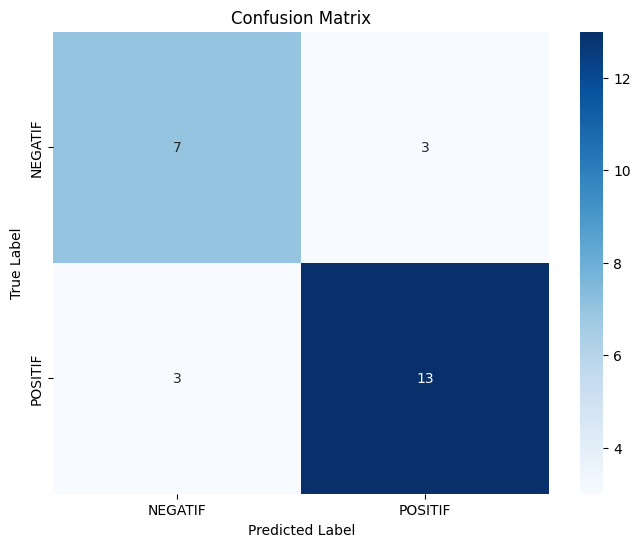

In [ ]:
# Evaluasi Akhir pada Test Set
def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

y_pred, y_test_tensors = get_predictions(model, test_data_loader, device)

print("\nLaporan Klasifikasi:")
# Menggunakan inverse_map untuk menampilkan nama label asli
inverse_label_map = {v: k for k, v in label_map.items()}
y_test_named = [inverse_label_map[label.item()] for label in y_test_tensors]
y_pred_named = [inverse_label_map[label.item()] for label in y_pred]

print(classification_report(y_test_named, y_pred_named, target_names=['NEGATIF', 'POSITIF']))


# Tampilkan Confusion Matrix
conf_matrix = confusion_matrix(y_test_named, y_pred_named, labels=['NEGATIF', 'POSITIF'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NEGATIF', 'POSITIF'], yticklabels=['NEGATIF', 'POSITIF'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd

# 1. Gabungkan hasil prediksi dengan data uji yang asli
df_test['predicted_label'] = y_pred_named
df_test['true_label'] = y_test_named

# 2. Filter untuk menemukan baris di mana prediksinya salah
error_df = df_test[df_test['predicted_label'] != df_test['true_label']]

print(f"Model membuat kesalahan pada {len(error_df)} dari {len(df_test)} data uji.")
print("-" * 50)

# 3. Tampilkan semua kesalahan untuk dianalisis
print("Detail Kesalahan Prediksi Model:")

# Mengatur agar teks ditampilkan penuh
pd.set_option('display.max_colwidth', None)

print(error_df[['text', 'true_label', 'predicted_label']])

Model membuat kesalahan pada 6 dari 26 data uji.
--------------------------------------------------
Detail Kesalahan Prediksi Model:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   